<a href="https://colab.research.google.com/github/bitterns/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [3]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2025-10 다운로드 후 업로드

In [3]:
!unzip tpss_bcycl_od_statnhm_202510.zip -d tpss_bcycl_od_statnhm_202510

Archive:  tpss_bcycl_od_statnhm_202510.zip
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251026.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251027.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251029.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251031.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251028.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251030.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251022.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251021.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251023.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251024.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251025.csv  
  inflating: tpss_bcycl_od_statnhm_202510/tpss_bcycl_od_statnhm_20251017.csv  
  inflati

## 12-2 CSV 형태의 데이터 수집

In [4]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202510/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    df = pd.read_csv(filename, encoding='cp949')
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True) # axis: 행 방향 0

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20251026,출발시간,850,ST-502,성내1동_014_1,ST-1580,오륜동_002_1,1,3.0,372.0
1,20251026,출발시간,610,ST-3277,용답동_017_2,ST-3099,용답동_021_1,1,5.0,1780.0
2,20251026,출발시간,1655,ST-658,창5동_006_1,ST-2117,쌍문2동_028_1,1,3.0,430.0
3,20251026,출발시간,2235,ST-279,양평2동_011_1,ST-2812,양평1동_020_1,1,11.0,1674.0
4,20251026,출발시간,35,ST-869,상계1동_003_1,ST-3050,도봉2동_001_5,1,4.0,711.0


## 12-3 기초 통계량 산출

In [5]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계: \n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계: \n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계: 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 6.29573e+06 |    6.29573e+06 |  6.29573e+06 |    6.07734e+06 |      6.07734e+06 |
| mean  | 2.0251e+07  | 1424.76        |  1.06275     |   23.2783      |   2629.29        |
| std   | 9.21939     |  552.203       |  0.281177    |   31.3525      |   3485.93        |
| min   | 2.0251e+07  |    0           |  1           |    1           |    300           |
| 25%   | 2.0251e+07  |  955           |  1           |    6           |    878           |
| 50%   | 2.0251e+07  | 1525           |  1           |   12           |   1512           |
| 75%   | 2.0251e+07  | 1840           |  1           |   27           |   2852           |
| max   | 2.0251e+07  | 2355           | 14           | 7715           | 265506           |
범주형 데이터 요약 통계: 
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명  

## 12-4 결측치 및 이상치 제거

In [6]:
## 결측치 제거
df = df.dropna()
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]
## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]
## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

In [7]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계: \n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("범주형 데이터 요약 통계: \n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계: 
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 2.89552e+06 |    2.89552e+06 |  2.89552e+06 |    2.89552e+06 |      2.89552e+06 |
| mean  | 2.0251e+07  | 1405.04        |  1.04957     |   19.8951      |   2093.99        |
| std   | 9.21709     |  552.058       |  0.241537    |   22.5992      |   1834.97        |
| min   | 2.0251e+07  |    0           |  1           |    2           |    300           |
| 25%   | 2.0251e+07  |  940           |  1           |    6           |    862           |
| 50%   | 2.0251e+07  | 1510           |  1           |   11           |   1455           |
| 75%   | 2.0251e+07  | 1830           |  1           |   24           |   2600           |
| max   | 2.0251e+07  | 2355           | 10           |  179           |   9999           |
범주형 데이터 요약 통계: 
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명  

## 12-5 날짜/시간 데이터 형식 변환

In [8]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')
## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}
df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

In [9]:
df.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리,요일
0,2025-10-26,출발시간,850,ST-502,성내1동_014_1,ST-1580,오륜동_002_1,1,3.0,372.0,일요일
1,2025-10-26,출발시간,610,ST-3277,용답동_017_2,ST-3099,용답동_021_1,1,5.0,1780.0,일요일
2,2025-10-26,출발시간,1655,ST-658,창5동_006_1,ST-2117,쌍문2동_028_1,1,3.0,430.0,일요일
3,2025-10-26,출발시간,2235,ST-279,양평2동_011_1,ST-2812,양평1동_020_1,1,11.0,1674.0,일요일
4,2025-10-26,출발시간,35,ST-869,상계1동_003_1,ST-3050,도봉2동_001_5,1,4.0,711.0,일요일


## 전처리 결과 확인

In [10]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                  |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:---------------------------|---------------:|-------------:|---------------:|-----------------:|
| count | 2895516                    |    2.89552e+06 |  2.89552e+06 |    2.89552e+06 |      2.89552e+06 |
| mean  | 2025-10-17 09:55:30.730688 | 1405.04        |  1.04957     |   19.8951      |   2093.99        |
| min   | 2025-10-01 00:00:00        |    0           |  1           |    2           |    300           |
| 25%   | 2025-10-10 00:00:00        |  940           |  1           |    6           |    862           |
| 50%   | 2025-10-19 00:00:00        | 1510           |  1           |   11           |   1455           |
| 75%   | 2025-10-25 00:00:00        | 1830           |  1           |   24           |   2600           |
| max   | 2025-10-31 00:00:00        | 2355           | 10           |  179           |   9999           |
| std   | nan                        |  552.0

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [11]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())
## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일    256186
화요일    367741
수요일    592526
목요일    626048
금요일    441452
토요일    319875
일요일    291688
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

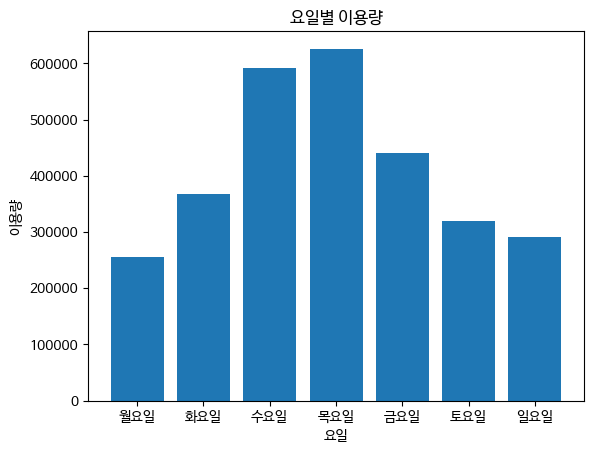

In [12]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

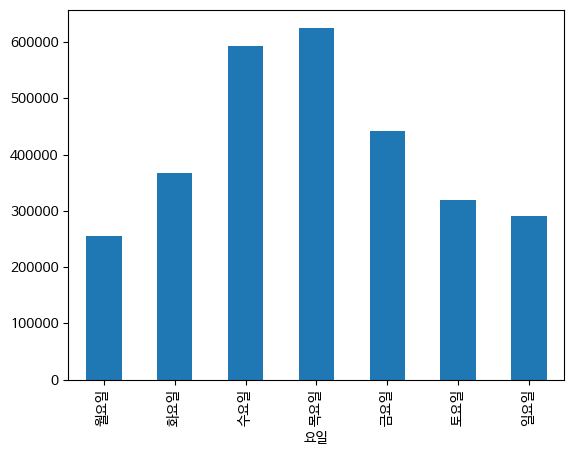

In [13]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0      55001
1      38421
2      25589
3      19211
4      16090
5      29148
6      61955
7     152005
8     227732
9     133621
10    107783
11    124815
12    135544
13    140590
14    144494
15    163084
16    197365
17    246243
18    261937
19    171548
20    144490
21    133357
22    110359
23     55134
Name: count, dtype: int64


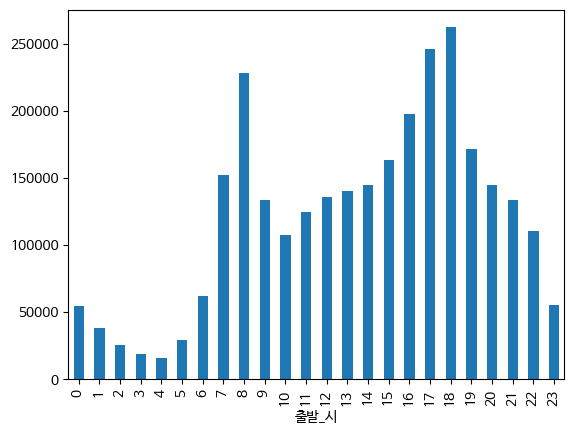

In [15]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
## 1740 -> 17시 40분. 100으로 나누어 hour 추출
df['출발_시'] = df['기준_시간대'] // 100

## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()

## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2025-10-01    146352
2025-10-02    149962
2025-10-03     72456
2025-10-04     89987
2025-10-05     43460
2025-10-06      9095
2025-10-07     22058
2025-10-08     93123
2025-10-09     89067
2025-10-10     12490
2025-10-11     46642
2025-10-12     86865
2025-10-13     25808
2025-10-14    114723
2025-10-15    105644
2025-10-16    132216
2025-10-17     98964
2025-10-18     81372
2025-10-19     92993
2025-10-20    115341
2025-10-21    118432
2025-10-22    126540
2025-10-23    131878
2025-10-24    133518
2025-10-25    101874
2025-10-26     68370
2025-10-27    105942
2025-10-28    112528
2025-10-29    120867
2025-10-30    122925
2025-10-31    124024
Name: count, dtype: int64


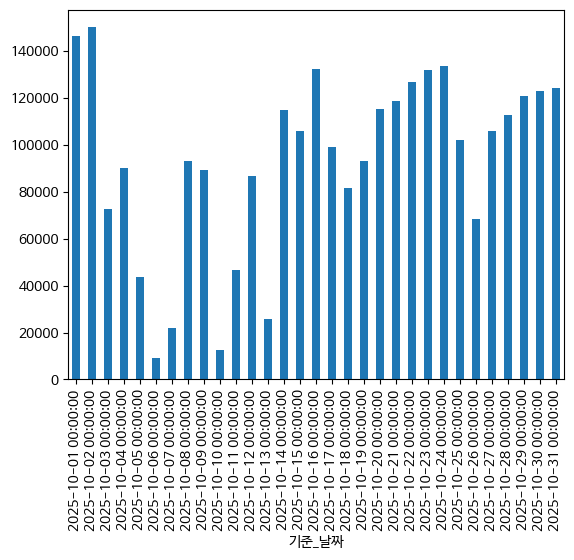

In [16]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2025_10.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [17]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2025_10.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)

,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2025-10-01,NaN,NaN,NaN,NaN
1,108,서울,2025-10-02,NaN,NaN,NaN,NaN
2,108,서울,2025-10-03,0.8,0.3,03:30,NaN
3,108,서울,2025-10-04,0.0,0.0,NaN,NaN
4,108,서울,2025-10-05,18.1,10.4,10:01,NaN


## 12-11 강수량 데이터 전처리

In [18]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

In [19]:
rain_df.head()

,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,서울,2025-10-01,0.0,NaN,NaN
1,서울,2025-10-02,0.0,NaN,NaN
2,서울,2025-10-03,0.8,0.3,03:30
3,서울,2025-10-04,0.0,0.0,NaN
4,서울,2025-10-05,18.1,10.4,10:01


## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [20]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, how='left', left_on='기준_날짜', right_on='일시')
## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,146352,서울,2025-10-01,0.0,NaN,NaN
1,149962,서울,2025-10-02,0.0,NaN,NaN
2,72456,서울,2025-10-03,0.8,0.3,03:30
3,89987,서울,2025-10-04,0.0,0.0,NaN
4,43460,서울,2025-10-05,18.1,10.4,10:01


## 12-13 이용량 및 강수량 시각화

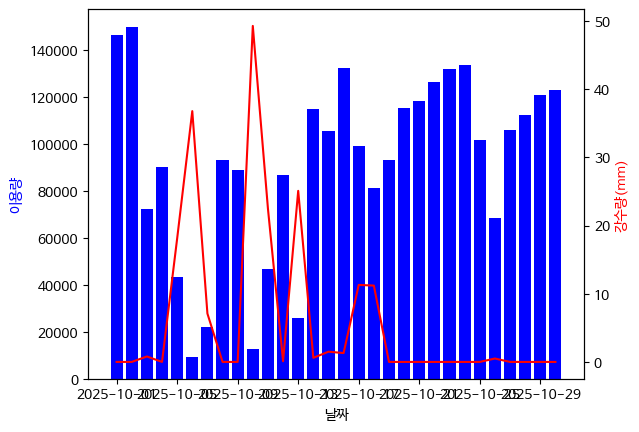

In [25]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'], color='b')
## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color='r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.7666934451100629


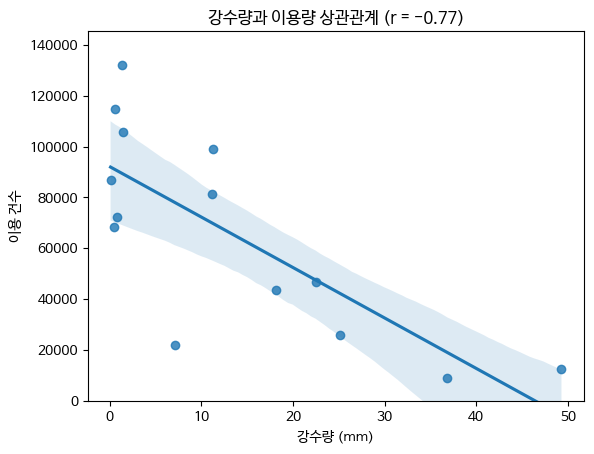

In [27]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산 (corr())
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
ax = sns.regplot(x='강수량(mm)', y='이용량', data=merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [28]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습
model = smf.ols(formula='이용량 ~ 강수량_mm', data=merged_onlyrain_df)
results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     17.11
Date:                Fri, 21 Nov 2025   Prob (F-statistic):            0.00138
Time:                        14:01:15   Log-Likelihood:                -161.45
No. Observations:                  14   AIC:                             326.9
Df Residuals:                      12   BIC:                             328.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.214e+04   9563.253      9.634      0.0